# Final Project: Bag of Words Method (Dog vs Cat Classification)

Hello! Welcome to my final project! Throughout this notebook, I will be exploring and implementing the nortious Bag of Words Method to distinguish pictures between dogs and cats. Based on the method of approach we learned in class, we will organize this project into three parts:
1. Histogram of Gradient Implementation
2. Dictionary Learning and Classifying
3. Testing our Model
4. Conclusion

There are **two main goal** of this project: 
1. Learning how this method is able to breakdown and analyze pictures using computer vision techniques we have learned in this course in combination of utilizing mathematical tools in the cluster and encode stage
2. The difference in accuarcy between the implementation of <i>Our HoG method vs. scikits's</i>

As you can most likely already tell, the style of approach that I have choosen to present this project is inspired by you, the professor :)! I geniuelly enjoyed the technique in which you presented the programming assignments and it being geared towards as a tutorial so I will do the same. 

Anything that has not been coded, made, or derived by me will be cited throughout this tutorial.

**NOTE:**
This project is HEAVILY resource intensive. We will be loading and processing lots of data, so it's going to need good amount of processing power and is going to eat up our ram. However, I built this project on a 8-core Apple M2 Chip w/ 8GBs of RAM while having many Chrome tabs open (lol) so you should be fine but if not, by all means feel free to adjust some of the parameters as you will see.

<b><i>With all of that being said, lets get to workin!</i></b>

Text(0.5, 1.0, 'My Dog Wesley')

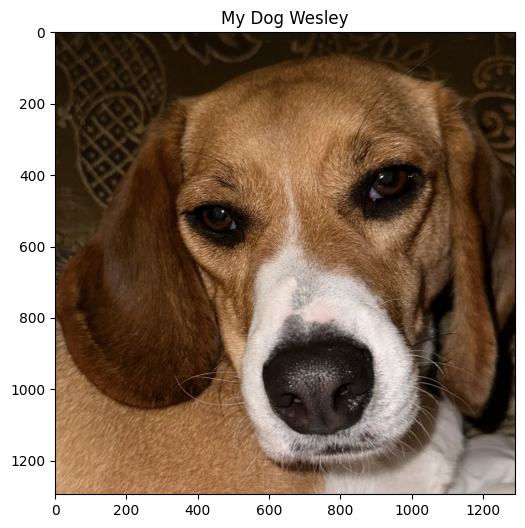

In [3]:
#Run this code to make sure all imports are loaded correctly w/o error 
#Picture of my dog should load
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog
from concurrent.futures import ThreadPoolExecutor
from skimage.draw import line_aa
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC

#load_image() function from programming assignments
def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

plt.figure(figsize=(12, 6))
plt.imshow(load_image("./pictures/mypup.jpg"))
plt.title("My Dog Wesley")

# P.1 Histogram of Gradient Implementation

In this first part, we need to create a multitude of words in so that we are able to categorize the similarity of features into a dictionary. To achieve this, we will first devise a method to extract features from the image so that we produce a feature vector. From there, as the aforementioned we categorize the similarities through clustering which leads to our system being able to learn the words. To be more specific, our <b>two step process</b> for this part will be as follows:

1. Compute Feature Descriptor Per Image Using <i>Histogram of Oriented Gradient</i>

Histogram of Oriented Gradient (HoG) is a feature descriptor which can capture edge information and object appeareances through computing gradient direction and magnitude within specified localized portions of an image in combination with histograms. We use this to produce a percise feature vector for then later can be used to produce words in our dictionary. The function is defined by me in accordance to the research papers that I have found. The **indepth procedure** is as follows:


<h4><b>1. Compute the Gradients in Both Directions of the Image</b></h4>

There are two ways to perform this step. 

You can use what we learn in class by convoluting the images using the Sobel Filters: 
$$I_x =  \begin{bmatrix} -1 & 0 & 1 \\ \end{bmatrix}$$ 
$$I_y =  \begin{bmatrix} -1 \\ 0 \\ 1 \\ \end{bmatrix}$$
Or by computing their central differences:
$$I_x(r,c) = I(r,c+1) - I(r,c-1)$$ 
$$I_y(r,c) = I(r-1,c) - I(r+1, c)$$
Where $I_x$ is the $x$-derivative of the image $I$, $I_y$ is the $y$-derivative of the image $I$, $r$ is the row, and $c$ is the column. 

I opted to compute their central differences. As we learned in class and based on the research paper, convolution with the Sobel Filters results in highly accurate derivates accross the image in the presence of noise. However, we may want to account for some noise as it may contribute to the accuracy of feature detection in later steps of our procedure. In addition, noise averaging will occur in the histogram computation. 

<h4><b>2. Computing Gradient Magnitude and Direction</b></h4>

After computation of $I_x$ and $I_y$, we now must compute the magnitude and direction based off those. This serves as a foundation of identifiable features, as it indicates the intensity of change given magnitude in a given direction per pixel. We will then use these to create a distribution through histograms, later in the code. We using the following equations:

$$\mu=\sqrt{I_x^2+I_y^2}$$
$$\theta=\frac{180}{\pi} (\tan_2^{-1}(I_y,I_x)\mod \pi)$$

with $\mu$ being the magnitude, and $\theta$ being the direction.

<h4><b>3. Cell Orientation Histograms</b></h4>

Now we are getting into the "histogram" part of our procedure. The idea behind this is that we categorize our features resembling the maginitude into its corresponding bin, with each bin representing a direction. Now, we don't want to apply this concept per pixel as it is not nesscary to differentiate each pixel, and computationaly expensive. Therefore, we compute a histogram of a fixed cell size that slides throughout the image, with a fixed number of bins. Here, we choose the cell size to be $8 x 8$ and the bin size to be $9$. As you will see in our code, we declare `cell x = image.shape[1] // C` and `cell y = image.shape[0] // C` to get multiples of the cell size in the $x$ and $y$ direction of our image. Then we construct our for loop and iterate per $9 x 9$ cell, computing this histogram. Thankfully for us, numpy has a histogram function call provided for us, so we just plug in our values, create this histogram, then add it to our feature vector: `np.histogram(cell_orientation, bins=B, range=(0, 180), weights=cell_magnitude)`.

<h4><b>4. Normalizing Our Histogram</b></h4>

The final step is now normalizing our histogram. It is important we do this as we attempt to eliminate as much noise possible, changes in illumination, and contrast. We do so by first reshaping our feature vector into a $3 x 3$ dimension, as we want to structure our vector to correspond its features to the cells of the image. Then we normalize per $2 x 2$ cell, as we choose a small dimension to capture the change in gradient, but eliminates the aforementioned. The equation is as follows:

$$b=\frac{b}{\sqrt{\lVert b \rVert^2 + \epsilon}}$$

With $b$ being the final result of the normalization and $\epsilon$ being a small constant so we do not get `divide-by-zero` errors.

<h4><b>5. Comparing our Results</b></h4>

I have provided a function that draws out our HoG of our image and the SciKit Library HoG implementation to compare our results. As you can see, it will not necessarily be the same but close with one another. This is most likely due to how the function is able to draw the image and will have some inaccuracies. Overall though, very close with one another.

(921600,)
(1295, 1290)


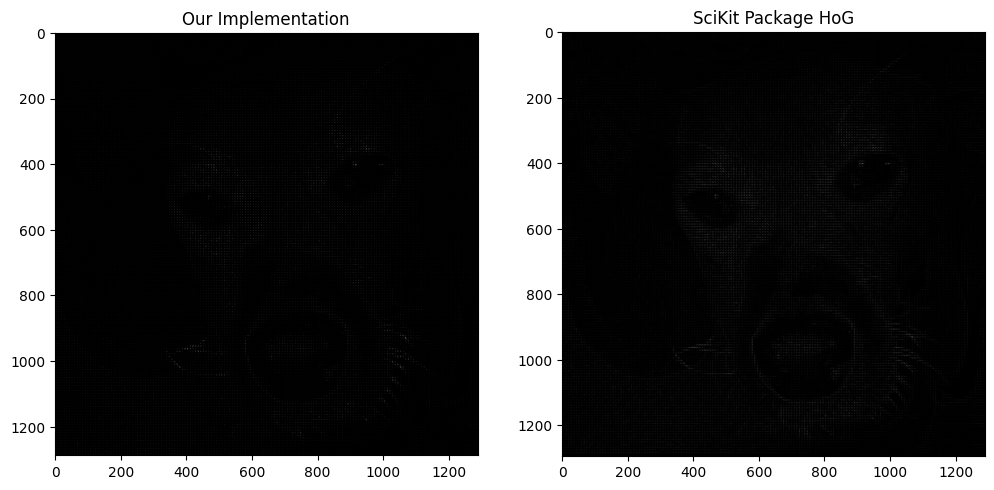

In [5]:
from skimage.draw import line_aa

#Switching Image back to Grayscale 
def load_image(filepath):
    img = Image.open(filepath).convert('L')  
    return (np.asarray(img).astype(float) / 255)


image = load_image("./pictures/mypup.jpg")

""" Self-Defined Function to compute our HoG descriptor """
def compute_hog(image):
    #Intializing our initial variables: cells, bins, width
    C = 8
    B = 9
    w = 180/B
    epsilon = 0.001
    hog_descriptor = list()
    
    # First Compute Derivates in X and Y direction using central difference
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    
    Ix[:, 1:-1] = image[:, 2:] - image[:, :-2]
    Iy[1:-1, :] = image[2:, :] - image[:-2, :]


    #Compute "mu constant" and "theta"
    mu = np.sqrt(np.square(Ix) + np.square(Iy))
    theta = (180 / np.pi) * (np.arctan2(Iy, Ix) % np.pi)
    
    #Getting our "sliding window" of CxC
    cell_x = image.shape[1] // C
    cell_y = image.shape[0] // C

    for i in range(cell_y):
        for j in range(cell_x):
            cell_magnitude = mu[i*C:(i+1)*C, j*C:(j+1)*C]
            cell_orientation = theta[i*C:(i+1)*C, j*C:(j+1)*C]
            hist, _ = np.histogram(cell_orientation, bins=B, range=(0, 180), weights=cell_magnitude)
            hog_descriptor.append(hist)

    
    # Reshape the descriptor array
    hog_descriptor = np.reshape(hog_descriptor, (cell_y, cell_x, B))

    # Normalize histograms over blocks of 2x2 cells
    block_normed = list()
    for y in range(cell_y - 1):
        for x in range(cell_x - 1):
            block = hog_descriptor[y:y+2, x:x+2, :].ravel()
            norm = np.linalg.norm(block, ord=2)  # L2 norm
            block = block / (norm**2 + epsilon)
            block_normed.append(block)

    hog_features = np.concatenate(block_normed)
    hog_features = hog_features / (np.linalg.norm(hog_features)**2 + epsilon)
    return hog_descriptor, hog_features

""" ChatGPT function to display our hog_descriptor """
def visualize_hog(img, hog_descriptor, cell_size, orientations):
    # Dimensions of each cell
    C = cell_size
    
    # Number of cells along x and y
    num_cells_x = img.shape[1] // C
    num_cells_y = img.shape[0] // C
    
    # Create an array to hold the visualized HoG features
    hog_image = np.zeros((num_cells_y * C, num_cells_x * C), dtype=float)
    
    # Go through each cell's histograms
    max_mag = np.array(hog_descriptor).max()
    for y in range(num_cells_y):
        for x in range(num_cells_x):
            for o in range(orientations):
                # Get the orientation angle and magnitude
                angle = 180 / orientations * o
                magnitude = hog_descriptor[y, x, o] / max_mag
                
                # Get the center of the cell
                center_x = x * C + C // 2
                center_y = y * C + C // 2
                
                # Calculate the direction vector ends based on the angle and magnitude
                dx = magnitude * C * np.cos(np.deg2rad(angle))
                dy = magnitude * C * np.sin(np.deg2rad(angle))
                
                # Draw the line on the hog_image
                x1 = center_x + dx / 2
                y1 = center_y - dy / 2
                x2 = center_x - dx / 2
                y2 = center_y + dy / 2
                rr, cc, val = line_aa(int(y1), int(x1), int(y2), int(x2))
                hog_image[rr, cc] += val * magnitude
    
    return hog_image


#SciKit hog function to compare results
hog_descriptor, hog_features = compute_hog(image)

fd, scikit_hog_image = hog(
    image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
)

print(fd.shape)
print(image.shape)

personal_hog_image = visualize_hog(image, hog_descriptor, 8, 9)



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Our Implementation")
plt.imshow(personal_hog_image, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("SciKit Package HoG")
plt.imshow(scikit_hog_image, cmap="gray")

# P.2 Dictionary Learning and Classifying

In this part, we will apply the HoG function that we created in the last part, to all of the images within our training dataset. We will use these feature vectors to compile a Bag of Words histogram through K-means cluster. We explore more indepth and the implementation process of all of theses in a bit, but for now we will focus on the steps we will take:

1. Load Training Our Set Images
2. Obtain Feature Vector for all Images for Learning
3. Building Bag of Words through Clustering/Encoding & Classifying Data



## P.2.1 Loading our Training Set Images

We will be doing batch processing of our training set using Tensorflow open source library, as it was **marginally** faster compared to my own implementation. There is some setting we must configure when processing our images. I found that by downscaling the image to <i>256x256</i>, computationally it was reasonable and anything higher would take way to long and it provided sufficient results in classification. We also choose grayscale as the color of our images isn't relvant in distinguishing between <i>dogs</i> or <i>cats</i>. We only care about the obsecurities of facial features and not the sensitivity of color throughout the image, if we were classifying different breeds it would be a different story.

I was able to load the images pretty fast (in 6 seconds), but it might vary for you as we are loading 10,000 images. To ensure that all of our images are loaded, I plotted the beginning and end of our image arrays to ensure that everything in between is loaded. 

Found 9892 files belonging to 2 classes.


2024-05-06 21:40:10.423950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Execution Time: 5.96 seconds


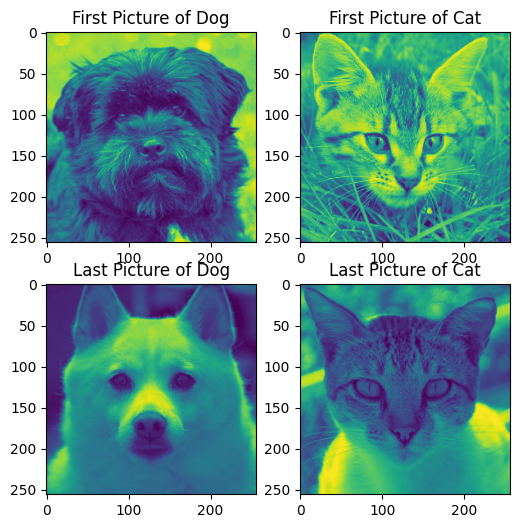

In [98]:
"""
Load Images from Directories of both Dogs & Cats
***NOTE***
We are loading thousands of images so it might take a little bit of time
Dog Pics #: 4,739
Cat Pics #: 5,153
***NOTE***
"""
import matplotlib.pyplot as plt
import tensorflow as tf
dogs = list()
cats = list()


start_time = time.perf_counter()
# Load images from directory
images = tf.keras.preprocessing.image_dataset_from_directory("./data", labels='inferred', batch_size=1024, color_mode="grayscale", image_size=(256, 256))


# Extract images of dogs and cats from the dataset
for images_batch, labels_batch in images:
    for image, label in zip(images_batch, labels_batch):
        if label == 1:  # dogs
            dogs.append(image.numpy().astype("float"))
        elif label == 0:  # cats
            cats.append(image.numpy().astype("float"))

end_time = time.perf_counter()
print(f"Execution Time: {end_time-start_time:.2f} seconds") 
dogs_and_cats = dogs + cats

# Display images
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.imshow(dogs[0])
plt.title("First Picture of Dog")

plt.subplot(2, 2, 2)
plt.imshow(cats[0])
plt.title("First Picture of Cat")

plt.subplot(2, 2, 3)
plt.imshow(dogs[-1])
plt.title("Last Picture of Dog")

plt.subplot(2, 2, 4)
plt.imshow(cats[-1])
plt.title("Last Picture of Cat")

plt.show()


## P.2.2 Obtain Feature Vector for all Images

Now that we have loaded all of our images with our desired settings, we can now compute the HoG (Histogram of Gradient) for all of our images. Again, we do this so that we can create clusters of our features, with having the clusters being synopsis to words. Therefore, we first must compile all of the features of our training set before performing any of that.

All we do here is just create an array of feature vectors per image. However, performing this sequentially is heavily slow. Especially given the complexity of our ```compute_hog``` function already. In order to decrease execution time, I paralized the code across all cores so that HoG(s) can be computed simutanelously. On my computer it took an execution time of 68 seconds, which for us is pretty fast. If it performs slow for you, you can change the ```chunksize=100``` parameter within the return call to attempt and increase computation time. Its synopsis to batch processing essentially, specifiying how many images to process per iteration. 

In [136]:
from sklearn.cluster import KMeans
from IPython.display import display, clear_output
from concurrent.futures import ProcessPoolExecutor
from image_processing import compute_hog
import time
# Assume hog_features is a 2D numpy array where each row is a HOG feature vector from an image

hog_list = list()
def main():
    with ProcessPoolExecutor() as executor:
        return list(executor.map(compute_hog, dogs_and_cats, chunksize=100))

if __name__ == '__main__':
    start_time = time.perf_counter()
    hog_list = main()
    end_time = time.perf_counter()
    print(f"Execution Time: {end_time-start_time:.2f} seconds") 
    


hog_features = np.array(hog_list)

Execution Time: 42.73 seconds


## P.2.3 Building Bag of Words through Clustering/Encoding & Classifying Data

In our final step, we will be using a bit of <i>Machine Learning</i> techniques to help us classify and predict images. For this we use the SciKit open library, as it seemed really diffcult to implement some of these techniques our own and it would be computationally way faster to do so. Please refer to the comments within the code that connects with the concepts being presented here. The idea is to cluster our features together, build our dictionary, and classify/train the data. Such as follows:

<h4>1. Cluster Features Together (Creation of Words):</h4>
You might notice that I use the words (no pun intended) clusters and words interchangbly. That is because they are conceptually equivalent to one another. The idea is that from the previous part we have extracted **ALL** of the features from every single image within our training set. Now we need to organize them into different clusters, through selecting centroids. These centroids create a fixed constraint that if a feature falls within its area, it belongs to that and the cluster. More formally:

$$J = \sum_{i=1}^n \min_{\mu_j \in C} \| x_i - \mu_j \|^2$$

Where $C$ is the set of all clusters, $X_i$ is our current feature that we are trying to designate within a cluster, and $\mu_j$ is the current centroid. We iterate through all of the centroids and see at which one has the lowest euclidean distance, hence $\min$. This is what is being done in the code, we build and specify the clusters and we fit it in there.

<h4>2. Building Bag-of-Words Vector (Building Our Dictonary):</h4>
After building our clusters, now we will build our vector. It is essentially a dictionary, which in itself is a histogram, where we count the number of occurances of words for each image. That is essentially how we encode it and create a model to help us simplify the type of features associated per image. We use for our mathematical tool next that helps build a stastical model for when predicting images.

<h4>3. Training and Classifying the Data using Support Vector Machine:</h4>
We now must choose a classifer to create a stastical model for us to classify wether a picture is a dog or a cat. I choose SVM since our classification is binary in the image having to either be a dog or a cat. It also seemed like the most easiest function call from the SciKit library and gave us optimal results. Based off of the lecture notes and implementation, we keep attempting to find the weightr vector $w$ that contains the largest margin between points. Mathematically formally:

$$
\min_{\mathbf{w}} \|\mathbf{w}\|
$$
subject to:
$$
y_i (\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1 \quad \text{for all } i=1,...,N
$$

Where $y_i$ is the corresponding label, $b$ being the bias, $x_i$ is the feature vector, and $i$ is current index position amongst all of our feature vectors of the training set. After we fit our data within this model, we have classified our Bag-of_Words and now we try and test some data!

**NOTE:**
This might take some time computationally, and we have many clusters to fit our data in. I found that 1000 clusters gave me the best accuracy. I was able to execute this in ```Execution Time: 201.57 seconds```.


In [137]:

"""
Building and Classifying our BoWs
"""
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC
import numpy as np

start_time = time.perf_counter()

## Part 1 
kmeans = MiniBatchKMeans(n_clusters=1000, batch_size=2048) 
visual_words = kmeans.fit_predict(hog_features)

## Part 2
bow_vectors = np.zeros((len(dogs_and_cats), 1000)) 
for i, word in enumerate(visual_words):
    bow_vectors[i, word] += 1

## Part 3
labels = np.array([1]*len(dogs) + [0]*len(cats)) 
classifier = LinearSVC()
classifier.fit(bow_vectors, labels)

end_time = time.perf_counter()
print(f"Execution Time: {end_time-start_time:.2f} seconds") 

Execution Time: 204.05 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [115]:
def load_image(filepath):
    img = Image.open(filepath)
    img = img.resize((256, 256))
    return (np.asarray(img).astype(np.double) / 255)[:, :, :3]

new_image = load_image("./pictures/cat1.jpg")
new_hog_feature = compute_hog(new_image).astype(np.double)
new_word = kmeans.predict(new_hog_feature.reshape(1, -1))
new_bow_vector = np.zeros(1000)
new_bow_vector[new_word] += 1
cluster_labels = {1: 'dog', 0: 'cat'}
predicted_label = classifier.predict([new_bow_vector])
# Output the predicted label for the image
print(f"The image is predicted to be a: {cluster_labels[predicted_label[0]]}")

The image is predicted to be a: dog


# P.3 Testing Our Data


We will be testing our data in four ways. We will reuse the training set and see if we are able to reclassify our image and a test set where the model has never seen these images before. We will be testing our own HoG implementation and the SciKit's implementation.

**NOTE:**
Our implementation might take some time to load the images, process them, and predict them. My execution time at max was 5 minutes. 

## P.3.1 Our Implementation of HoG Test

In [120]:
"""ChatGPT's Implementation 
"""
import numpy as np
import tensorflow as tf
from skimage.feature import hog

# Function to compute HOG features
def compute_batch_hog(images_batch):
    return np.array([compute_hog(image) for image in images_batch])

# Load your dataset
start_time = time.perf_counter()
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "./data", labels='inferred', label_mode='binary', batch_size=200, color_mode="grayscale", image_size=(256, 256)
)

error = 0
img_total = 0

for images_batch, labels_batch in test_set:
    images_batch = images_batch.numpy().astype("float")  # Convert batch to numpy array once
    new_hog_features = compute_batch_hog(images_batch)  # Compute HOG features for the batch
    
    # Predict clusters (visual words) for each HOG feature in the batch
    new_words = kmeans.predict(new_hog_features)
    new_bow_vectors = np.zeros((len(images_batch), 1000))
    
    for idx, word in enumerate(new_words):
        new_bow_vectors[idx, word] += 1
    
    # Predict labels using SVM
    predicted_labels = classifier.predict(new_bow_vectors)
    
    # Compute errors
    error += np.sum(predicted_labels != labels_batch.numpy().flatten())
    img_total += len(images_batch)
    
end_time = time.perf_counter()
print(f"Execution Time: {end_time-start_time:.2f} seconds") 
accuracy = (img_total - error) / img_total * 100
print(f"Accuracy: {accuracy:.2f}%")

#72%


Found 9892 files belonging to 2 classes.
Execution Time: 307.27 seconds
Accuracy: 71.98%


2024-05-06 23:31:46.507871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [122]:
import numpy as np
import tensorflow as tf
from skimage.feature import hog

# Function to compute HOG features
def compute_batch_hog(images_batch):
    return np.array([compute_hog(image) for image in images_batch])

# Load your dataset
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "./test_set", labels='inferred', label_mode='binary', batch_size=1024, color_mode="grayscale", image_size=(256, 256)
)

error = 0
img_total = 0

for images_batch, labels_batch in test_set:
    images_batch = images_batch.numpy().astype("float")  # Convert batch to numpy array once
    new_hog_features = compute_batch_hog(images_batch)  # Compute HOG features for the batch
    
    # Predict clusters (visual words) for each HOG feature in the batch
    new_words = kmeans.predict(new_hog_features)
    new_bow_vectors = np.zeros((len(images_batch), 1000))
    
    for idx, word in enumerate(new_words):
        new_bow_vectors[idx, word] += 1
    
    # Predict labels using SVM
    predicted_labels = classifier.predict(new_bow_vectors)
    
    # Compute errors
    error += np.sum(predicted_labels != labels_batch.numpy().flatten())
    img_total += len(images_batch)

accuracy = (img_total - error) / img_total * 100
print(f"Accuracy: {accuracy:.2f}%")


Found 2023 files belonging to 2 classes.
Accuracy: 52.50%


2024-05-06 23:34:23.004423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## P.3.2 SciKit HoG Test

In [142]:
import numpy as np
import tensorflow as tf
from skimage.feature import hog

# Function to compute HOG features
def compute_batch_hog(images_batch):
    return np.array([hog(
    image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=False,
    channel_axis=-1
) for image in images_batch])

# Load your dataset
start_time = time.perf_counter()
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "./data", labels='inferred', label_mode='binary', batch_size=200, color_mode="grayscale", image_size=(256, 256)
)

error = 0
img_total = 0

for images_batch, labels_batch in test_set:
    images_batch = images_batch.numpy().astype("float")  # Convert batch to numpy array once
    new_hog_features = compute_batch_hog(images_batch)  # Compute HOG features for the batch
    
    # Predict clusters (visual words) for each HOG feature in the batch
    new_words = kmeans.predict(new_hog_features)
    new_bow_vectors = np.zeros((len(images_batch), 1000))
    
    for idx, word in enumerate(new_words):
        new_bow_vectors[idx, word] += 1
    
    # Predict labels using SVM
    predicted_labels = classifier.predict(new_bow_vectors)
    
    # Compute errors
    error += np.sum(predicted_labels != labels_batch.numpy().flatten())
    img_total += len(images_batch)
    
end_time = time.perf_counter()
print(f"Execution Time: {end_time-start_time:.2f} seconds") 
accuracy = (img_total - error) / img_total * 100
print(f"Accuracy: {accuracy:.2f}%")

#74%


Found 9892 files belonging to 2 classes.
Execution Time: 127.97 seconds
Accuracy: 91.91%


2024-05-06 23:52:36.704032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [146]:
import numpy as np
import tensorflow as tf
from skimage.feature import hog

# Function to compute HOG features
def compute_batch_hog(images_batch):
    return np.array([hog(
    image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=False,
    channel_axis=-1
) for image in images_batch])

# Load your dataset
start_time = time.perf_counter()
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "./test_set", labels='inferred', label_mode='binary', batch_size=200, color_mode="grayscale", image_size=(256, 256)
)

error = 0
img_total = 0

for images_batch, labels_batch in test_set:
    images_batch = images_batch.numpy().astype("float")  # Convert batch to numpy array once
    new_hog_features = compute_batch_hog(images_batch)  # Compute HOG features for the batch
    
    # Predict clusters (visual words) for each HOG feature in the batch
    new_words = kmeans.predict(new_hog_features)
    new_bow_vectors = np.zeros((len(images_batch), 1000))
    
    for idx, word in enumerate(new_words):
        new_bow_vectors[idx, word] += 1
    
    # Predict labels using SVM
    predicted_labels = classifier.predict(new_bow_vectors)
    
    # Compute errors
    error += np.sum(predicted_labels != labels_batch.numpy().flatten())
    img_total += len(images_batch)
    
end_time = time.perf_counter()
print(f"Execution Time: {end_time-start_time:.2f} seconds") 
accuracy = (img_total - error) / img_total * 100
print(f"Accuracy: {accuracy:.2f}%")



Found 2023 files belonging to 2 classes.
Execution Time: 25.87 seconds
Accuracy: 54.72%


2024-05-06 23:56:18.368310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# P.4 Conclusion

The most puzzling part from our results is testing our training set data and the marginal difference between ```scikit``` and ```Our Implementation``` of Histogram of Gradient. The scikit's gave us **92%** accuracy while ours gave us only **72%**. Nonetheless, we were able to achieve an above **50%** which was our goal. To my best guess, I assumed the scikit was able to prevail against ours due to its implementation in possibly taking the gradient of the image and how it minimized the error.

Getting a low accuracy for both implementations was sort of expected for the test set. It is very diffcult to identify completely new images, even though we got above **50%**, we can definetly get better results by possibly adding more data or using a neural network.

Overall, I am pretty stastified with our results and I'm glad you came for the journey.

Thank you! :)

## Citations:

[1] Bag of Words Method Lecture 20 Slides \
[2] https://courses.cs.duke.edu/fall17/compsci527/notes/hog.pdf \
[3] https://iopscience.iop.org/article/10.1088/1742-6596/1314/1/012176/pdf \
[4] https://ieeexplore.ieee.org/abstract/document/6606268 \
[5] https://www.sciencedirect.com/science/article/pii/S0743731517301569?via=ihub#b25 \
[6] https://ieeexplore.ieee.org/document/1467360